In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from sklearn import datasets
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

### Clustering the [Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset with mixture models

This is perhaps the best known database to be found in the pattern recognition literature. Fisher's paper is a classic in the field and is referenced frequently to this day. (See Duda & Hart, for example.) The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other. 

In [2]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data   # Load features
y = iris.target # Load targets

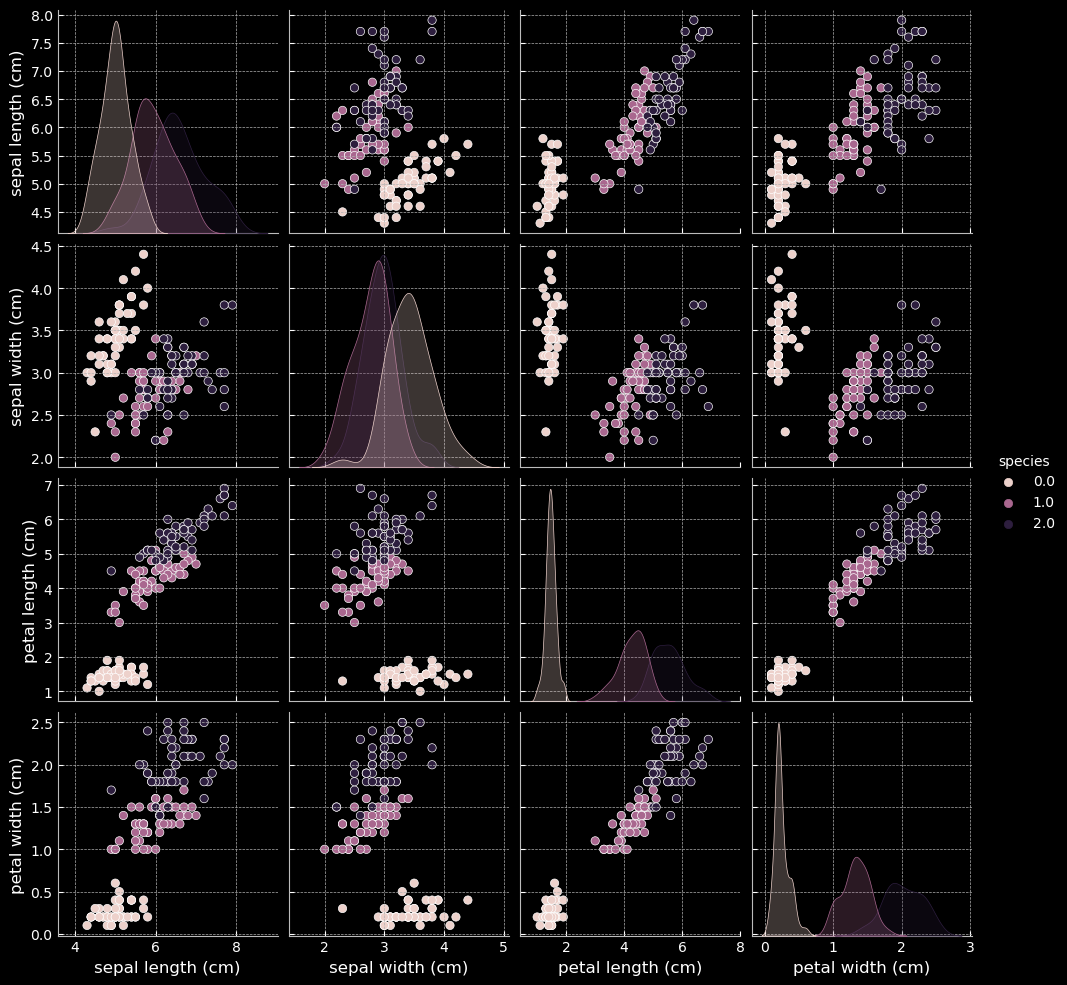

In [3]:
# Paired plot using seaborn
# creating a dataframe for plotting
c_names = iris.feature_names
c_names.append('species')
df = pd.DataFrame(data = np.hstack((iris.data, iris.target.reshape(-1, 1))), columns = c_names)
sns.pairplot(df[iris.feature_names], hue = "species", diag_kind = "kde")
plt.show()

### EM Mixture models for clustering

In [4]:
from scipy.stats import norm
from scipy.stats import multivariate_normal

## Clear the environment and load required libraries
np.random.seed(1)

## Setup data
x          = X
n          = x.shape[0]         # Number of observations
p          = x.shape[1]         # Number of features
KK         = 3                  # Number of classes or componentes

epsilon    = 10e-7              # Stopping criteria

### EM algorithm for Clustering

In [5]:
# Initialize the parameters of the algorithm
numruns = 15
v_sum   = np.zeros((numruns, n, KK))
QQ_sum  = np.zeros(numruns)

for ss in range(numruns):
  ## Initialize the parameters
  w     = np.ones(KK) / KK # Assign equal weight to each component to start with
  mu    = multivariate_normal.rvs(mean = np.mean(x, axis = 0), cov = 3 * np.cov(x.T), size = KK)   # Random cluster centers randomly spread over the support of the data
  Sigma = np.zeros((KK, p, p))  # Initial covariance mat deviation
  Sigma[0] = np.cov(x.T)        # Covariance matrix of first component
  Sigma[1] = np.cov(x.T)        # Covariance matrix of second component
  Sigma[2] = np.cov(x.T)        # Covariance matrix of third component

  s  = 0     # Counter of the current iteration
  sw = False # Decide when the algorithm will end
  QQ = np.NINF  # Value of Q to monitor convergence
  QQ_out = []

  ## Checking convergence of the algorithm
  while(not sw):
    ## Expectation (E) step
    v = np.zeros((n, KK))
    for k in range(KK):
      v[:, k] = np.log(w[k]) + multivariate_normal.logpdf(mean = mu[k, :], cov = Sigma[k, :, :], x = x, allow_singular = True) # Compute the log of the weights
    for i in range(n):
      v[i, :] = np.exp(v[i, :] - max(v[i, : ])) / np.sum(np.exp(v[i, :] - max(v[i, :])))  # Go from logs to actual weights in a numerically stable manner

    ## Maximization (M) step
    # Weights
    w = np.mean(v, axis = 0)
    # Mus
    mu = np.zeros((KK, p))
    for k in range(KK):
      for i in range(n):
        # Update Mu
        mu[k, :] = mu[k, :] + (v[i, k] * x[i, :])
      mu[k, :] = mu[k, :] / np.sum(v[:, k])

    # Standard deviations
    Sigma = np.zeros((KK, p, p))
    for k in range(KK):
      for i in range(n):
        # Add new axis to operate properly
        Sigma[k, :, :] = Sigma[k, :, :] + (v[i,k] * np.dot((x[i, :] - mu[k, :])[:, np.newaxis], (x[i, :] - mu[k, :])[:, np.newaxis].T))
      Sigma[k, :, :] = Sigma[k, :, :] / np.sum(v[:, k])

    #print('Mu values \n{}'.format(mu))
    #print('Sigma values \n{}'.format(Sigma))
    #print('Weight values \n{}'.format(w))

    ##Check convergence
    QQn = 0 # Value of Q function at current iteration
    for i in range(n):
      for k in range(KK):
        QQn = QQn + v[i, k] * (np.log(w[k]) + multivariate_normal.logpdf(mean = mu[k, :], cov = Sigma[k, :, :], x = x[i, :], allow_singular = True))

    # If relative error is less than epsilon stop
    if(np.abs(QQn - QQ) / np.abs(QQn) < epsilon):
      sw = True
    QQ = QQn
    QQ_out.append(QQ)
    s = s + 1

  v_sum[ss, :, :] = v
  QQ_sum[ss]  = QQ_out[s - 1]
  print('The current run is: {}'.format(ss))

The current run is: 0
The current run is: 1
The current run is: 2
The current run is: 3
The current run is: 4
The current run is: 5
The current run is: 6
The current run is: 7
The current run is: 8
The current run is: 9
The current run is: 10
The current run is: 11
The current run is: 12
The current run is: 13
The current run is: 14


### Results obtained by EM

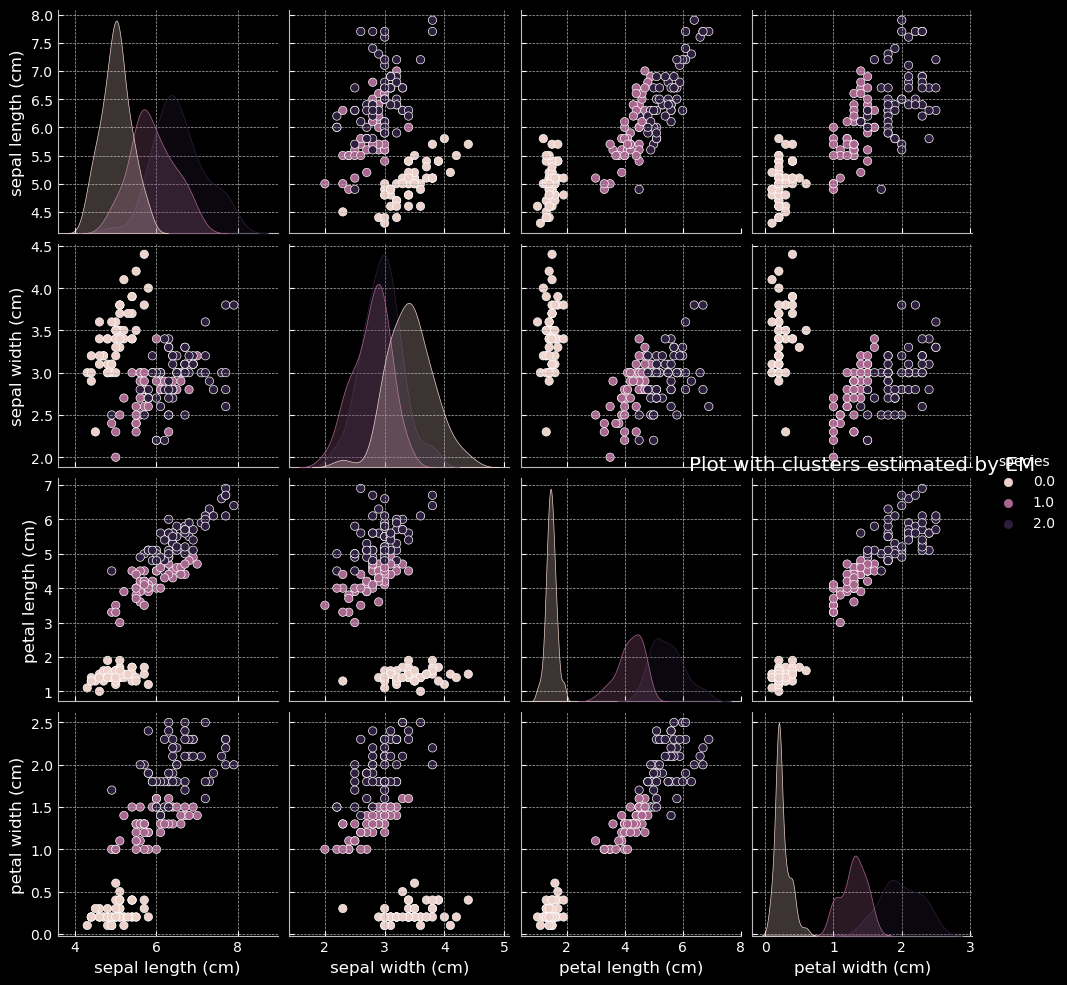

The adjusted rand score is: 0.9038742317748124


In [6]:
from sklearn.metrics.cluster import adjusted_rand_score

# Computing indexes with EM
cc = np.argmax(v_sum[np.argmax(QQ_sum), :, :], axis = 1)

# Paired plot
df = pd.DataFrame(data = np.hstack((iris.data, cc.reshape(-1, 1))), columns = c_names)
sns.pairplot(df[iris.feature_names], hue = "species", diag_kind = "kde")
plt.title('Plot with clusters estimated by EM')
plt.show()

print('The adjusted rand score is: {}'.format(adjusted_rand_score(y, cc)))

### Results obtained by KMeans

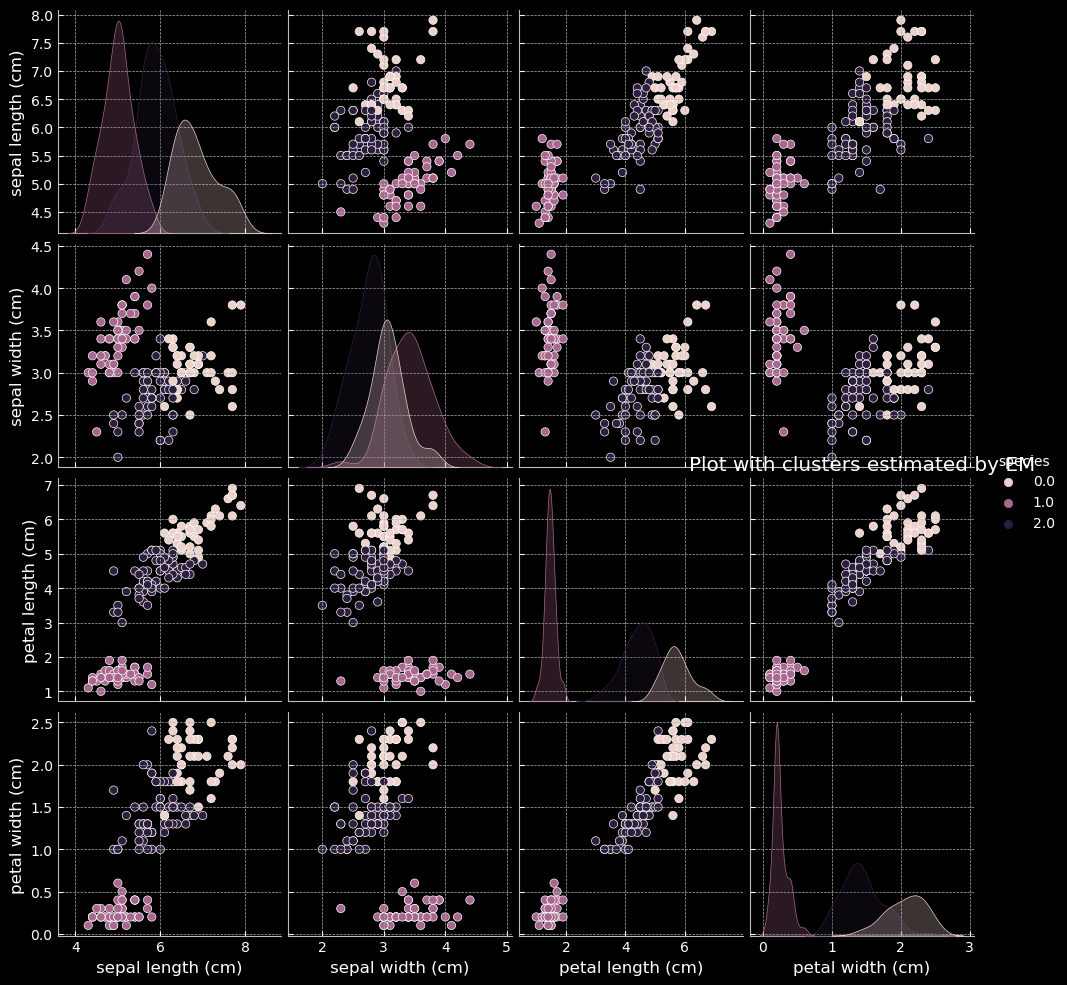

The adjusted rand score is: 0.7302382722834697


In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state=0).fit(x)
cc_kmeans = kmeans.predict(x)

# Paired plot
df = pd.DataFrame(data = np.hstack((iris.data, cc_kmeans.reshape(-1, 1))), columns = c_names)
sns.pairplot(df[iris.feature_names], hue = "species", diag_kind = "kde")
plt.title('Plot with clusters estimated by EM')
plt.show()

print('The adjusted rand score is: {}'.format(adjusted_rand_score(y, cc_kmeans)))

The EM model perform way better than the KMeans model! EM mixture models for clustering a way too powerful.